In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
#from sklearn.cross_validation import LeaveOneOut, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR




from count_lagged_complaints import *
from chris_rasmus_graph_features import *

from processing import *
%matplotlib inline

In [4]:
offc = pd.read_csv('data/toy.officer_data.csv',sep=',')
cmpl = pd.read_csv('data/toy.complaint_data.csv', sep=',')

In [5]:
scale_days = 365
last_train_year = 2012
base_year = last_train_year
base_month = 12
base_day = 31
lag_max = 4
deg_thresh = 5

r = add_complaints_by_year(last_train_year, lag_max, cmpl, offc) 

Adding graph features

In [6]:
complaint_df0 = pd.read_csv('data/toy.complaint_data_with_LAG_at_365_on_2012_12_31.csv',sep=',')

In [7]:
#complaint_df0 = add_lag_to_complaints(cmpl, scale_days, base_year, base_month, base_day)
# complaint_df = add_complaint_severity(complaint_df0)

# build bipartite graph
G = build_bipartite_graph(complaint_df0)
officer_ids = offc['officer_id'].unique()


# get feature dictionaries
num_nbr_complaints_dict = num_of_nbr_complaints(G, officer_ids, lag_max)
num_high_offenders = num_high_offender_nbrs(G, officer_ids, deg_thresh)
num_nbr_complaints_dict_pf = num_of_nbr_complaints_past_future(G, officer_ids, lag_max)


In [8]:
A=pd.DataFrame(dict([(k,pd.Series(v)) for k,v in num_nbr_complaints_dict.items()])).transpose()
A.columns = ['cmpl0','cmpl1','cmpl2','cmpl3']

B=pd.DataFrame(dict([(k,pd.Series(v)) for k,v in num_high_offenders.items()])).transpose() 
B.columns = ['num_high_offndr']
C=pd.DataFrame(dict([(k,pd.Series(v)) for k,v in num_nbr_complaints_dict_pf.items()])).transpose()
C.columns = ['cmpl0_p','cmpl1_p','cmpl2_p','cmpl3_p','cmpl0_f','cmpl1_f','cmpl2_f','cmpl3_f']


r_A = r.merge(A, left_on = 'officer_id', right_index = 1, how = 'outer')
r_AB = r_A.merge(B, left_on = 'officer_id', right_index = 1, how = 'outer')
r_AB = r_AB.fillna(0);
r_C = r_AB.merge(C, left_on = 'officer_id', right_index = 1, how = 'outer')
r_C.head()

,first.name,last.name,appointed.date,race,gender,birth.year,age,rank,primary,secondary,...,cmpl3,num_high_offndr,cmpl0_p,cmpl1_p,cmpl2_p,cmpl3_p,cmpl0_f,cmpl1_f,cmpl2_f,cmpl3_f
0,KARINA,AARON,2005-09-26,HISPANIC,FEMALE,1980,35,POLICE OFFICER,0,1,...,8,12,9,10,3,1,0,0,7,7
1,AZIZ,ABDELMAJEID,2008-04-28,A_OTHER,MALE,1984,31,POLICE OFFICER,0,0,...,18,22,17,25,24,4,0,0,0,16
2,JENNIFER,ACCARDO,2004-11-29,WHITE,FEMALE,1979,37,POLICE OFFICER,0,0,...,1,1,1,1,0,0,0,0,1,1
3,ROSEMARY,ACCARDO,1986-08-11,WHITE,FEMALE,1952,63,POLICE OFFICER,0,0,...,1,0,0,0,1,1,0,0,0,0
4,THOMAS,ACCARDO,2001-04-30,WHITE,MALE,1967,49,POLICE OFFICER,0,1,...,0,0,1,1,0,0,0,0,0,0


Generating feature matrix

In [9]:
# Making X vector (features)
# X = r_AB
X=r_C

#Dropping "FirstName", "LastName", "BirthYear","Rank"
X = X.drop(X.columns[[0,1,5,7,11]], axis=1)
# Getting years from apponted dates and normalizing
# temp = X[X.columns[0]].astype(str).str[0:4].astype(int)
# X[X.columns[0]] = (temp-np.mean(temp))/np.std(temp)
X[X.columns[0]] = X[X.columns[0]].astype(str).str[0:4].astype(int)


#Encoding categorical variables
X_cat = X[X.columns[[1,2]]]
XX=X_cat.apply(LabelEncoder().fit_transform)
X[X.columns[[1,2]]] = XX
np.where(np.isnan(X))
X_race = pd.get_dummies(X['race'])
X_race.columns = ['race0','race1','race2','race3']
X = X.drop(X.columns[[1]], axis=1)
X = X.join(X_race, how='outer')

X.head()
X.columns

Index([u'appointed.date', u'gender', u'age', u'primary', u'secondary', u'tertiary', u'Lag0', u'Lag-1', u'Lag-2', u'Lag-3', u'cmpl0', u'cmpl1', u'cmpl2', u'cmpl3', u'num_high_offndr', u'cmpl0_p', u'cmpl1_p', u'cmpl2_p', u'cmpl3_p', u'cmpl0_f', u'cmpl1_f', u'cmpl2_f', u'cmpl3_f', u'race0', u'race1', u'race2', u'race3'], dtype='object')

Generating output vector

In [9]:
# Making Y vector

Y = add_complaints_by_year(2015, 3, cmpl, offc)

Y=Y[[Y.columns[Y.shape[1]-1],Y.columns[Y.shape[1]-2],Y.columns[Y.shape[1]-3]]]
Y=Y.sum(axis=1)

Y.head()

0    0
1    0
2    0
3    0
4    3
dtype: float64

In [11]:
X.columns

Index([u'appointed.date', u'gender', u'age', u'primary', u'secondary', u'tertiary', u'Lag0', u'Lag-1', u'Lag-2', u'Lag-3', u'cmpl0', u'cmpl1', u'cmpl2', u'cmpl3', u'num_high_offndr', u'cmpl0_p', u'cmpl1_p', u'cmpl2_p', u'cmpl3_p', u'cmpl0_f', u'cmpl1_f', u'cmpl2_f', u'cmpl3_f', u'race0', u'race1', u'race2', u'race3'], dtype='object')

## data viz?

In [20]:
from sklearn.manifold import TSNE

In [22]:
RS = 20150101

In [10]:
XnoG = X.copy()

In [16]:
dropcols = [3,4,5]+range(10,23)

In [17]:
XnoG = X.drop(X.columns[dropcols], axis=1)

In [18]:
XnoG.head()

,appointed.date,gender,age,Lag0,Lag-1,Lag-2,Lag-3,race0,race1,race2,race3
0,2005,0,35,0,3,2,2,0,0,1,0
1,2008,1,31,0,0,5,4,1,0,0,0
2,2004,0,37,0,1,0,0,0,0,0,1
3,1986,0,63,0,0,0,1,0,0,0,1
4,2001,1,49,1,0,1,0,0,0,0,1


In [23]:
features_proj = TSNE(random_state=RS).fit_transform(XnoG)

In [25]:
fpx = features_proj[:,0]
fpy = features_proj[:,1]

In [28]:
Y.shape

(3884,)

In [30]:
X.head()

,appointed.date,gender,age,primary,secondary,tertiary,Lag0,Lag-1,Lag-2,Lag-3,...,cmpl2_p,cmpl3_p,cmpl0_f,cmpl1_f,cmpl2_f,cmpl3_f,race0,race1,race2,race3
0,2005,0,35,0,1,0,0,3,2,2,...,3,1,0,0,7,7,0,0,1,0
1,2008,1,31,0,0,1,0,0,5,4,...,24,4,0,0,0,16,1,0,0,0
2,2004,0,37,0,0,1,0,1,0,0,...,0,0,0,0,1,1,0,0,0,1
3,1986,0,63,0,0,1,0,0,0,1,...,1,1,0,0,0,0,0,0,0,1
4,2001,1,49,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1


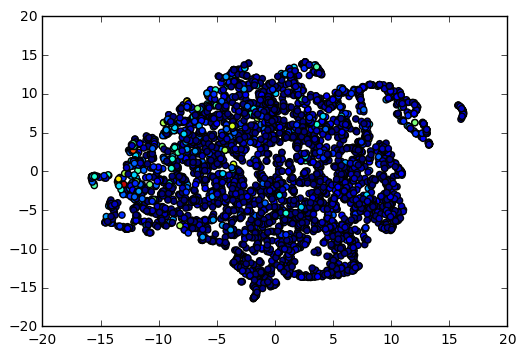

In [29]:
plt.scatter(fpx,fpy,c=Y)
plt.show()

Predictive models

0.643169821776


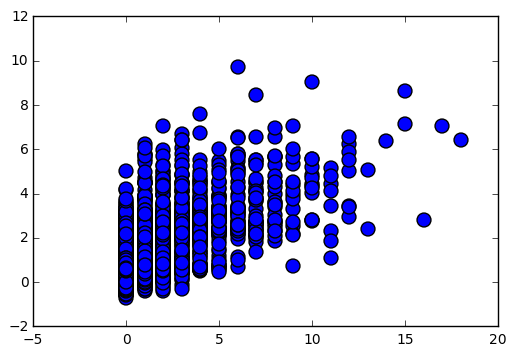

In [11]:
# LINEAR model


clf = linear_model.LinearRegression()
# predicts = cross_val_predict(clf, X, Y, cv=3)

clf.fit(X,Y)
predicts = clf.predict(X)

plt.scatter(Y,predicts, s=100)
mean_squared_error(Y, predicts)
correlation = np.corrcoef(Y, predicts)[0,1]
print(correlation)

0.620553501128


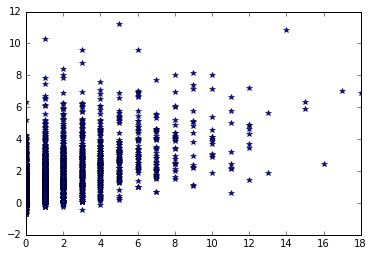

In [10]:
# GBM

clf = GradientBoostingRegressor(n_estimators=500,learning_rate=0.05,min_samples_split=5,
        min_samples_leaf=15,max_depth=5,max_features='sqrt',random_state=12,
        subsample =0.8,verbose=0,warm_start = True)

predicts = cross_val_predict(clf, X, Y, cv=3)

# clf.fit(X,Y)
# predicts = clf.predict(X)

mean_squared_error(Y, predicts)
plt.plot(Y,predicts,'*')
correlation = np.corrcoef(Y, predicts)[0,1]
print(correlation)

# clf.fit(X,Y)
# imp = clf.feature_importances_


In [12]:
plt.bar(np.arange(0,np.shape(X)[1]),imp)

NameError: name 'imp' is not defined

0.612966560397


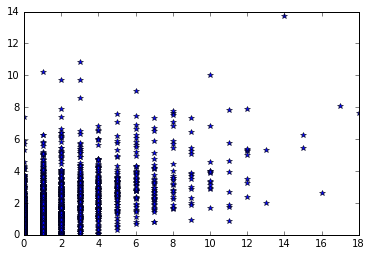

In [16]:
clf = RandomForestRegressor(n_estimators=100)
predicts = cross_val_predict(clf, X, Y, cv=3)

# clf.fit(X,Y)
# predicts = clf.predict(X)

mean_squared_error(Y, predicts)
plt.plot(Y,predicts,'*')
correlation = np.corrcoef(Y, predicts)[0,1]
print(correlation)

clf.fit(X,Y)
imp = clf.feature_importances_


0.453140343531


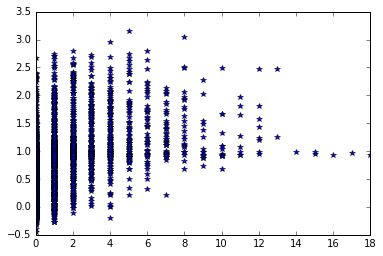

In [20]:
clf = SVR(kernel='rbf', degree=3, gamma='auto')

predicts = cross_val_predict(clf, X, Y, cv=3)

#clf.fit(X2,Y)
#predicts = clf.predict(X2)

mean_squared_error(Y, predicts)
plt.plot(Y,predicts,'*')
correlation = np.corrcoef(Y, predicts)[0,1]
print(correlation)